# **Chapter 2: End-to-End Machine Learning Project**

**Tujuan:**

Membangun alur kerja lengkap untuk memprediksi harga rumah di California menggunakan dataset housing.csv.

Langkah-langkah Utama:
* Mengunduh dan memuat data.
* Eksplorasi data awal.
* Pra-pemrosesan (mengisi data kosong, encoding, scaling).
* Split data train/test dengan stratifikasi.
* Membangun pipeline dengan Scikit-Learn.

# **Import Library**

In [1]:
# Import library utama
import os
import tarfile
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import modul dari Scikit-Learn
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# **Download dan Muat Data**

In [2]:
# URL sumber data
DATA_URL = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DATA_URL + "datasets/housing/housing.tgz"

# Fungsi untuk mengunduh dan mengekstrak data
def ambil_data_perumahan(url=HOUSING_URL, path=HOUSING_PATH):
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "housing.tgz")
    urllib.request.urlretrieve(url, tgz_path)
    with tarfile.open(tgz_path) as file:
        file.extractall(path=path)

# Fungsi untuk membaca data CSV
def muat_data_perumahan(path=HOUSING_PATH):
    csv_path = os.path.join(path, "housing.csv")
    return pd.read_csv(csv_path)

# Eksekusi
ambil_data_perumahan()
data = muat_data_perumahan()
data.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


# **Eksplorasi Data**
Tujuan:

Memahami bentuk, ukuran, dan kualitas data sebelum membangun model.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


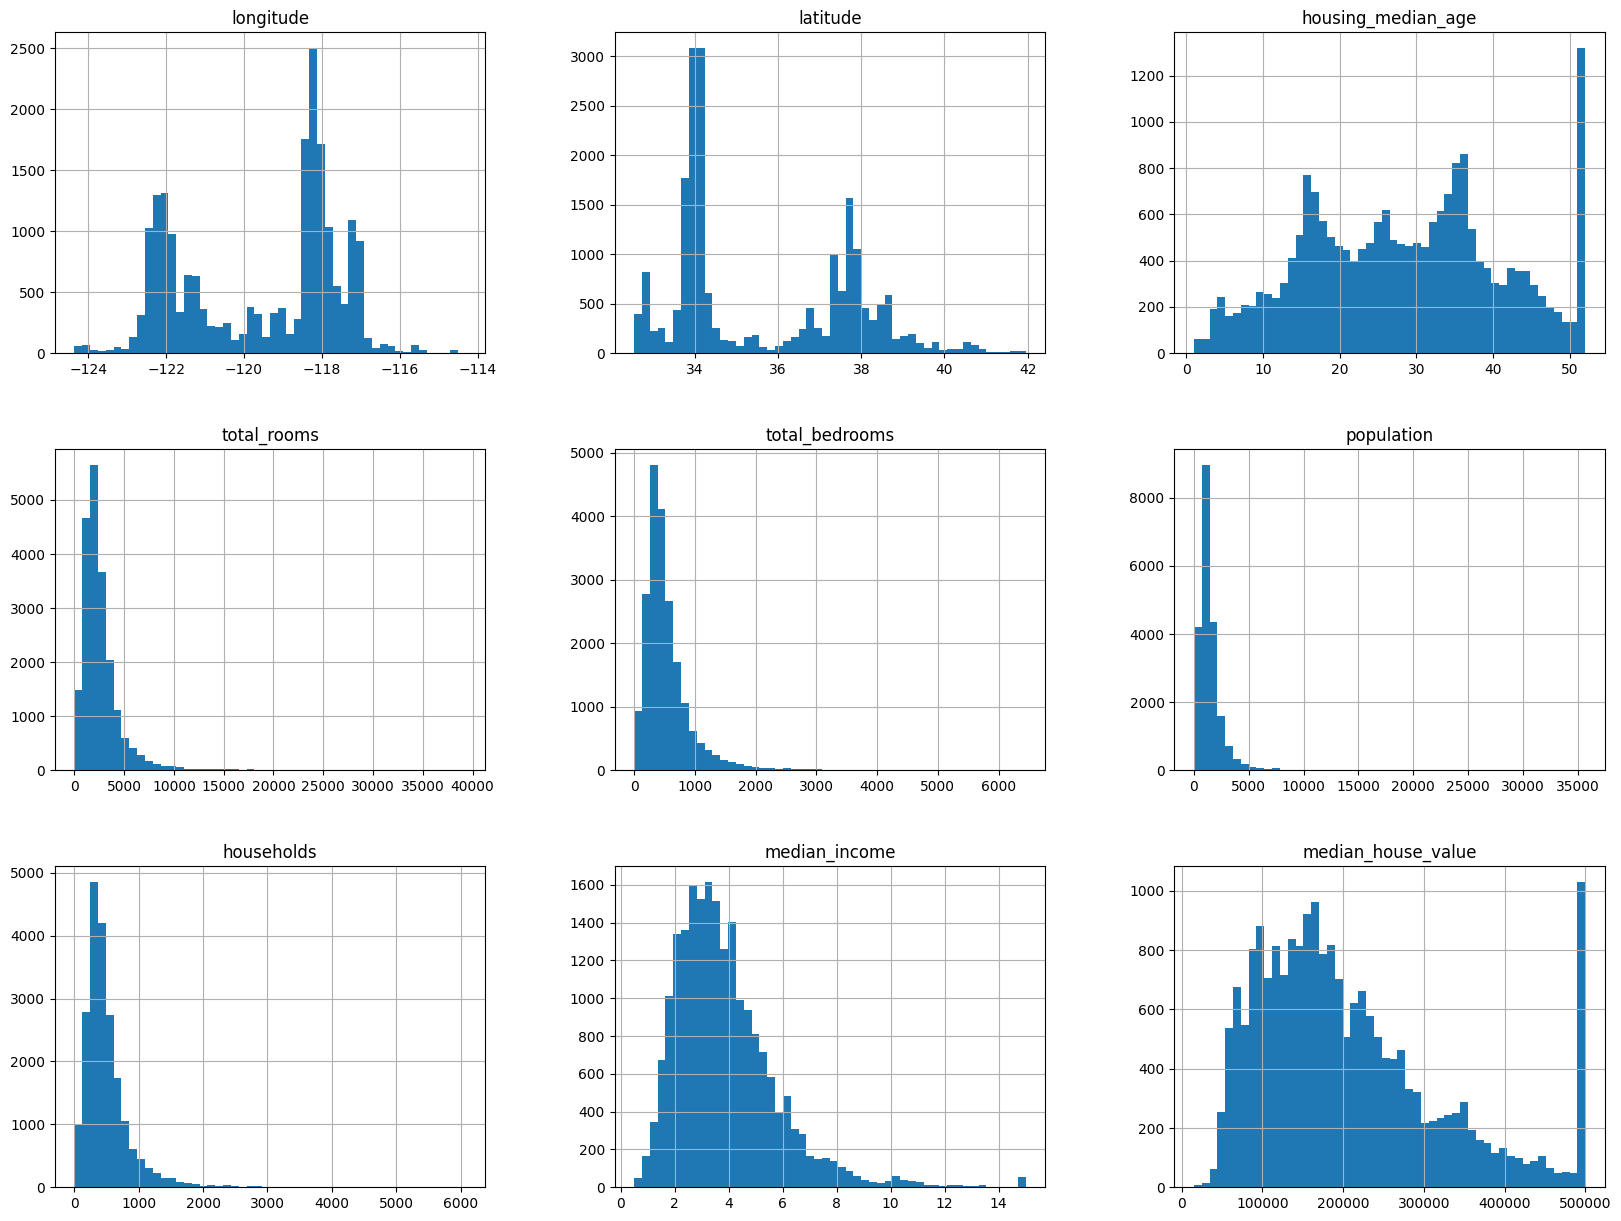

In [4]:
# Menampilkan info umum dataset
data.info()

# Statistik deskriptif
data.describe()

# Melihat distribusi kategori
data["ocean_proximity"].value_counts()

# Menampilkan histogram dari semua fitur numerik
data.hist(bins=50, figsize=(20, 15))
plt.show()


# **Membuat Stratified Train/Test Split**
Tujuan:

Membagi data pelatihan dan pengujian secara proporsional terhadap fitur penting (contoh: median income) untuk menghindari bias sampel.

In [6]:
# Menambahkan kolom kategori berdasarkan pendapatan
data["income_cat"] = pd.cut(data["median_income"],
                            bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                            labels=[1, 2, 3, 4, 5])

# Membuat split stratifikasi
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(data, data["income_cat"]):
    strat_train_set = data.loc[train_idx]
    strat_test_set = data.loc[test_idx]

# Hapus kolom kategori income agar tidak digunakan dalam pelatihan
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)


# **Visualisasi Geografis**
Tujuan:

Melihat pola spasial berdasarkan fitur lokasi (longitude, latitude), populasi, dan harga rumah.

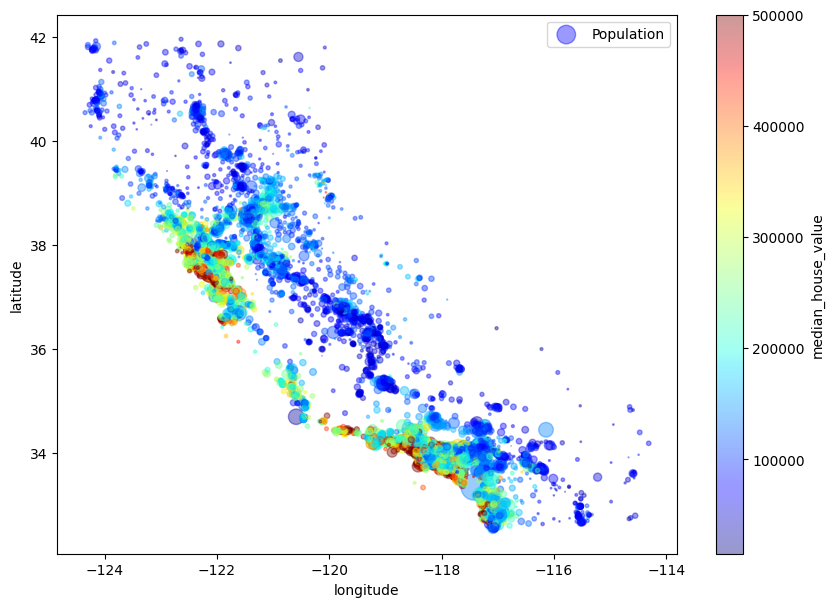

In [7]:
housing = strat_train_set.copy()

housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="Population",
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             figsize=(10, 7))

plt.legend()
plt.show()


# **Data Preprocessing Pipeline**
Tujuan:

* Menyiapkan data sebelum dimasukkan ke model ML. Proses ini mencakup:
* Menangani nilai kosong
* Membuat fitur baru
* Normalisasi (scaling)
* Encoding fitur kategori



In [8]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Pisahkan label dan fitur
housing_labels = housing["median_house_value"].copy()
housing = housing.drop("median_house_value", axis=1)

# Kelas untuk menambahkan fitur buatan
class TambahFiturAtribut(BaseEstimator, TransformerMixin):
    def __init__(self, tambah_bedroom_per_room=True):
        self.tambah_bedroom_per_room = tambah_bedroom_per_room

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        rooms_per_household = X[:, 3] / X[:, 6]
        population_per_household = X[:, 5] / X[:, 6]
        if self.tambah_bedroom_per_room:
            bedrooms_per_room = X[:, 4] / X[:, 3]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

# Pisahkan fitur numerik
housing_num = housing.drop("ocean_proximity", axis=1)

# Pipeline untuk numerik
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("fitur_tambahan", TambahFiturAtribut()),
    ("scaler", StandardScaler()),
])

# Definisikan kolom numerik dan kategorikal
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# Gabungkan semua dalam satu pipeline
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Jalankan pipeline untuk seluruh data
housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared.shape)


(16512, 16)
